In [18]:
from os.path import splitext
from os import listdir
import numpy as np
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image
import matplotlib.pyplot as plt
import imageio
from imgaug import augmenters as iaa
import imgaug as ia
import numpy as np

In [35]:
class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=1, augmentations = None):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                    if not file.startswith('.')]
        logging.info(f'Creating dataset with {len(self.ids)} examples')
        self.augmentations = augmentations # save the augmentations

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))
        
        img_nd = np.array(pil_img)
        print(img_nd.shape)
        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)
        
        imgplot = plt.imshow(pil_img)
        plt.show()
        #rounding the image
        
        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255
#         img_trans = np.around(img_trans)
#         imgplot = plt.imshow(img_trans)
#         plt.show()
        return img_trans

    def __getitem__(self, i):
        idx = self.ids[i]
        mask_file = glob(self.masks_dir + idx + '.*')
        img_file = glob(self.imgs_dir + idx + '.*')
        img_file2 = glob('data/imgs_jan/' + idx + '.*')
        assert len(mask_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'
        mask = Image.open(mask_file[0])
        mask = mask.convert('L')
        img = Image.open(img_file[0])
        img2 = Image.open(img_file2[0])
        assert img.size == mask.size, \
            f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'
        
        img = self.preprocess(img, self.scale)
        mask = self.preprocess(mask, self.scale)
        img2 = self.preprocess(img2, self.scale)
        
        stack_img = np.vstack((img, img2))
        print(c.shape)
        return {
            'mask': torch.from_numpy(mask).type(torch.FloatTensor)
        }

In [36]:
dir_img = 'data/imgs/'
dir_mask = 'data/masks/'
dir_checkpoint = 'checkpoints/'
dataset = BasicDataset(dir_img, dir_mask, 1)


(467, 467, 3)


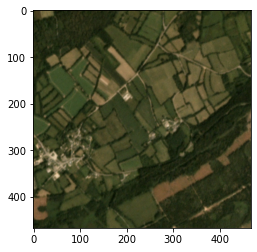

(467, 467)


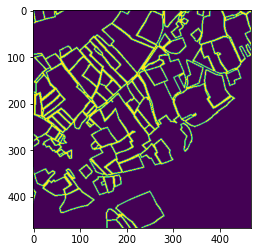

(467, 467, 3)


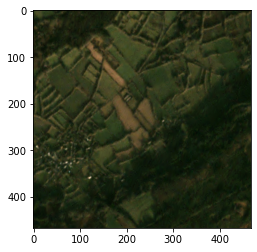

(6, 467, 467)


In [37]:
x = dataset[6]